In [ ]:
%pip install pandas scikit-learn matplotlib openpyxl

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame
#imputer = SimpleImputer(strategy='mean')
#df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
def read_file():
    try: 
        excel_file = pd.ExcelFile('Data.xlsx')
        sheet_names = excel_file.sheet_names

        print(f"Sheet names: {sheet_names}")
        sheets_data = {}
        for sheet in sheet_names:

            sheets_data[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
            print(f"\n{sheet} sheet loaded with {sheets_data[sheet].shape[0]} rows and {sheets_data[sheet].shape[1]}")
        
        # accessing individual sheets
        main_sheet = sheets_data['Data']
        def_sheet = sheets_data['DEF']
        mid_sheet = sheets_data['MID']
        att_sheet = sheets_data['OFF']

        # dataframes
        return sheets_data, main_sheet, def_sheet, mid_sheet, att_sheet
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None, None, None, None, None

# Function to display basic information about a dataframe
def explore_dataframe(df, title):
    if df is None:
        print(f"No data available for {title}")
        return
    
    print(f"\n--- {title} Exploration ---")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn names:")
    print(df.columns.tolist())
    print("\nData types:")
    print(df.dtypes)
    print("\nSummary statistics:")
    print(df.describe())
    print("\nMissing values count:")
    print(df.isnull().sum())


In [ ]:
sheets_data, main_sheet, def_sheet, mid_sheet, att_sheet = read_file()

explore_dataframe(main_sheet, "Main Sheet")
explore_dataframe(def_sheet, "Def Sheet")       
explore_dataframe(mid_sheet, "Mid Sheet")
explore_dataframe(att_sheet, "Att Sheet")   


I choose to clean the dataset based on criteria 
- has null fields
- |z_score| >= 2 on field minutes played 
- where minutes played and appearance do not correlate e.g (cell 170, Data sheet) : Cesc Fabregas 176 minutes played and 1 appeareance. Should not be possible given max  120 minutes in a game

In [ ]:
import seaborn as sns
def minutes_vs_apps_analysis(df):
    """Analyze the relationship between minutes played and appearances"""
    if 'Minutes played' not in df.columns or 'Apps' not in df.columns:
        print("Minutes played or Apps columns not found")
        return
    
    # Create a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Apps'], df['Minutes played'], alpha=0.5)
    
    # Add reference lines for reasonable limits (90 min regular time, 120 min with extra time)
    max_apps = df['Apps'].max()
    plt.axline((0, 0), (1, 90), color='green', linestyle='--', label='90 min/game')
    plt.axline((0, 0), (1, 120), color='red', linestyle='--', label='120 min/game (with extra time)')
    
    plt.xlabel('Appearances')
    plt.ylabel('Minutes Played')
    plt.title('Minutes Played vs. Appearances')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate minutes per appearance
    df_with_apps = df[df['Apps'] > 0].copy()
    df_with_apps['Minutes_per_App'] = df_with_apps['Minutes played'] / df_with_apps['Apps']
    
    # Histogram of minutes per appearance
    plt.figure(figsize=(10, 6))
    sns.histplot(df_with_apps['Minutes_per_App'], bins=30, kde=True)
    
    # Add reference lines
    plt.axvline(90, color='green', linestyle='--', label='90 min (regular time)')
    plt.axvline(120, color='red', linestyle='--', label='120 min (with extra time)')
    
    plt.xlabel('Minutes per Appearance')
    plt.ylabel('Count')
    plt.title('Distribution of Minutes per Appearance')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Show summary statistics for minutes per appearance
    print("\nMinutes per Appearance Statistics:")
    print(df_with_apps['Minutes_per_App'].describe())
    
    # Identify suspicious entries
    suspicious = df_with_apps[df_with_apps['Minutes_per_App'] > 120]
    if len(suspicious) > 0:
        print(f"\nSuspicious entries (>120 min/app): {len(suspicious)}")
        print(suspicious[['Name', 'Apps', 'Minutes played', 'Minutes_per_App']].head(10))
        if len(suspicious) > 10:
            print(f"... and {len(suspicious) - 10} more")

In [ ]:
minutes_vs_apps_analysis(main_sheet)

In [ ]:
minutes_vs_apps_analysis(def_sheet)

In [ ]:
minutes_vs_apps_analysis(mid_sheet)

In [ ]:
minutes_vs_apps_analysis(att_sheet)

NOTE: adjust the second column Name to something like 'Player Info' to avoid ambiguity with the other column name, in the main 'Data' sheet

In [ ]:
from scipy import stats
def clean_dataset(df, player_name_col='Name'):
    """
    Clean the dataset by handling null values, removing outliers, and fixing inconsistencies
    between minutes played and appearances.
    
    Args:
        df (pd.DataFrame): The dataframe to clean
        player_name_col (str): The name of the column containing player names
        
    Returns:
        pd.DataFrame: The cleaned dataframe
        dict: A dictionary with information about the cleaning process
    """
    print(f"\n--- Cleaning Dataset ---")
    original_shape = df.shape
    results = {
        'original_rows': original_shape[0],
        'missing_values_removed': 0,
        'outliers_removed': 0,
        'inconsistent_minutes_removed': 0
    }
    
    # Make a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Step 1: Handle missing values
    # Count missing values
    missing_counts = cleaned_df.isnull().sum()
    print(f"\nMissing values before cleaning:")
    print(missing_counts[missing_counts > 0])
    
    # Remove rows with any missing values
    rows_with_nulls = cleaned_df[cleaned_df.isnull().any(axis=1)]
    if not rows_with_nulls.empty:
        print(f"\nRows with missing values to be removed ({len(rows_with_nulls)}):")
        if player_name_col in rows_with_nulls.columns:
            print(rows_with_nulls[player_name_col].tolist())
    
    cleaned_df = cleaned_df.dropna()
    results['missing_values_removed'] = original_shape[0] - cleaned_df.shape[0]
    
    print(f"\nRows removed due to missing values: {results['missing_values_removed']}")
    
    # Step 2: Remove outliers based on z-score for minutes played
    if 'Minutes played' in cleaned_df.columns:
        # Calculate z-scores
        z_scores = stats.zscore(cleaned_df['Minutes played'])
        abs_z_scores = np.abs(z_scores)
        
        # Identify outliers where |z| >= 3 
        outliers_mask = abs_z_scores >= 3
        outliers = cleaned_df[outliers_mask]
        
        if not outliers.empty:
            print(f"\nOutliers in Minutes played (|z| >= 3) to be removed ({len(outliers)}):")
            if player_name_col in outliers.columns:
                outlier_names = outliers[[player_name_col, 'Minutes played']].values.tolist()
                for name, minutes in outlier_names[:10]:  # Show first 10 to avoid long output
                    print(f"  {name}: {minutes} minutes (z-score: {z_scores[outliers_mask][outlier_names.index([name, minutes])]:0.2f})")
                if len(outlier_names) > 10:
                    print(f"  ... and {len(outlier_names) - 10} more")
        
        # Remove outliers
        cleaned_df = cleaned_df[~outliers_mask]
        results['outliers_removed'] = len(outliers)
        
        print(f"\nRows removed due to outliers in Minutes played: {results['outliers_removed']}")
    
    # Step 3: Remove duplicates
    cleaned_df = cleaned_df.drop_duplicates()
    print(f"\nRows removed due to duplicates: {original_shape[0] - cleaned_df.shape[0]}")

    # Step 4: Remove rows with less zero appearances
    if 'Apps' in cleaned_df.columns:    
        zero_apps_mask = cleaned_df['Apps'] <= 0
        zero_apps_rows = cleaned_df[zero_apps_mask]
        
        if not zero_apps_rows.empty:
            print(f"\nRows with zero appearances to be removed ({len(zero_apps_rows)}):")
            if player_name_col in zero_apps_rows.columns:
                print(zero_apps_rows[player_name_col].tolist())
        
        cleaned_df = cleaned_df[~zero_apps_mask]
        results['zero_appearances_removed'] = len(zero_apps_rows)
        
        print(f"\nRows removed due to zero appearances: {results['zero_appearances_removed']}")

    # Step 5: Fix inconsistencies between minutes played and appearances
    if 'Minutes played' in cleaned_df.columns and 'Apps' in cleaned_df.columns:
        # Calculate minutes per appearance
        cleaned_df['Minutes_per_App'] = cleaned_df['Minutes played'] / cleaned_df['Apps'].replace(0, np.nan)
        
        # Flag inconsistent rows (minutes per app > 100)
        # Using 100 instead of 120 to allow for some margin given averages
        inconsistent_mask = cleaned_df['Minutes_per_App'] > 120
        inconsistent_rows = cleaned_df[inconsistent_mask]
        
        if not inconsistent_rows.empty:
            print(f"\nInconsistent minutes/appearances to be removed ({len(inconsistent_rows)}):")
            if player_name_col in inconsistent_rows.columns:
                inconsistent_data = inconsistent_rows[[player_name_col, 'Minutes played', 'Apps', 'Minutes_per_App']].values.tolist()
                for name, minutes, apps, mins_per_app in inconsistent_data[:10]:  # Show first 10
                    print(f"  {name}: {minutes} minutes, {apps} apps ({mins_per_app:.1f} min/app)")
                if len(inconsistent_data) > 10:
                    print(f"  ... and {len(inconsistent_data) - 10} more")
        
        # Remove inconsistent rows
        cleaned_df = cleaned_df[~inconsistent_mask]
        results['inconsistent_minutes_removed'] = len(inconsistent_rows)
        
        # Drop the temporary column
        cleaned_df = cleaned_df.drop('Minutes_per_App', axis=1)
        
        print(f"\nRows removed due to inconsistent minutes/appearances: {results['inconsistent_minutes_removed']}")
    
    # Final report
    final_shape = cleaned_df.shape
    total_removed = original_shape[0] - final_shape[0]
    
    print(f"\n--- Cleaning Summary ---")
    print(f"Original rows: {original_shape[0]}")
    print(f"Rows removed: {total_removed} ({total_removed/original_shape[0]*100:.1f}%)")
    print(f"Remaining rows: {final_shape[0]}")
    
    return cleaned_df, results



In [ ]:
cleaned_main, clean_res = clean_dataset(main_sheet)

visualize effects of cleaning the dataset. 

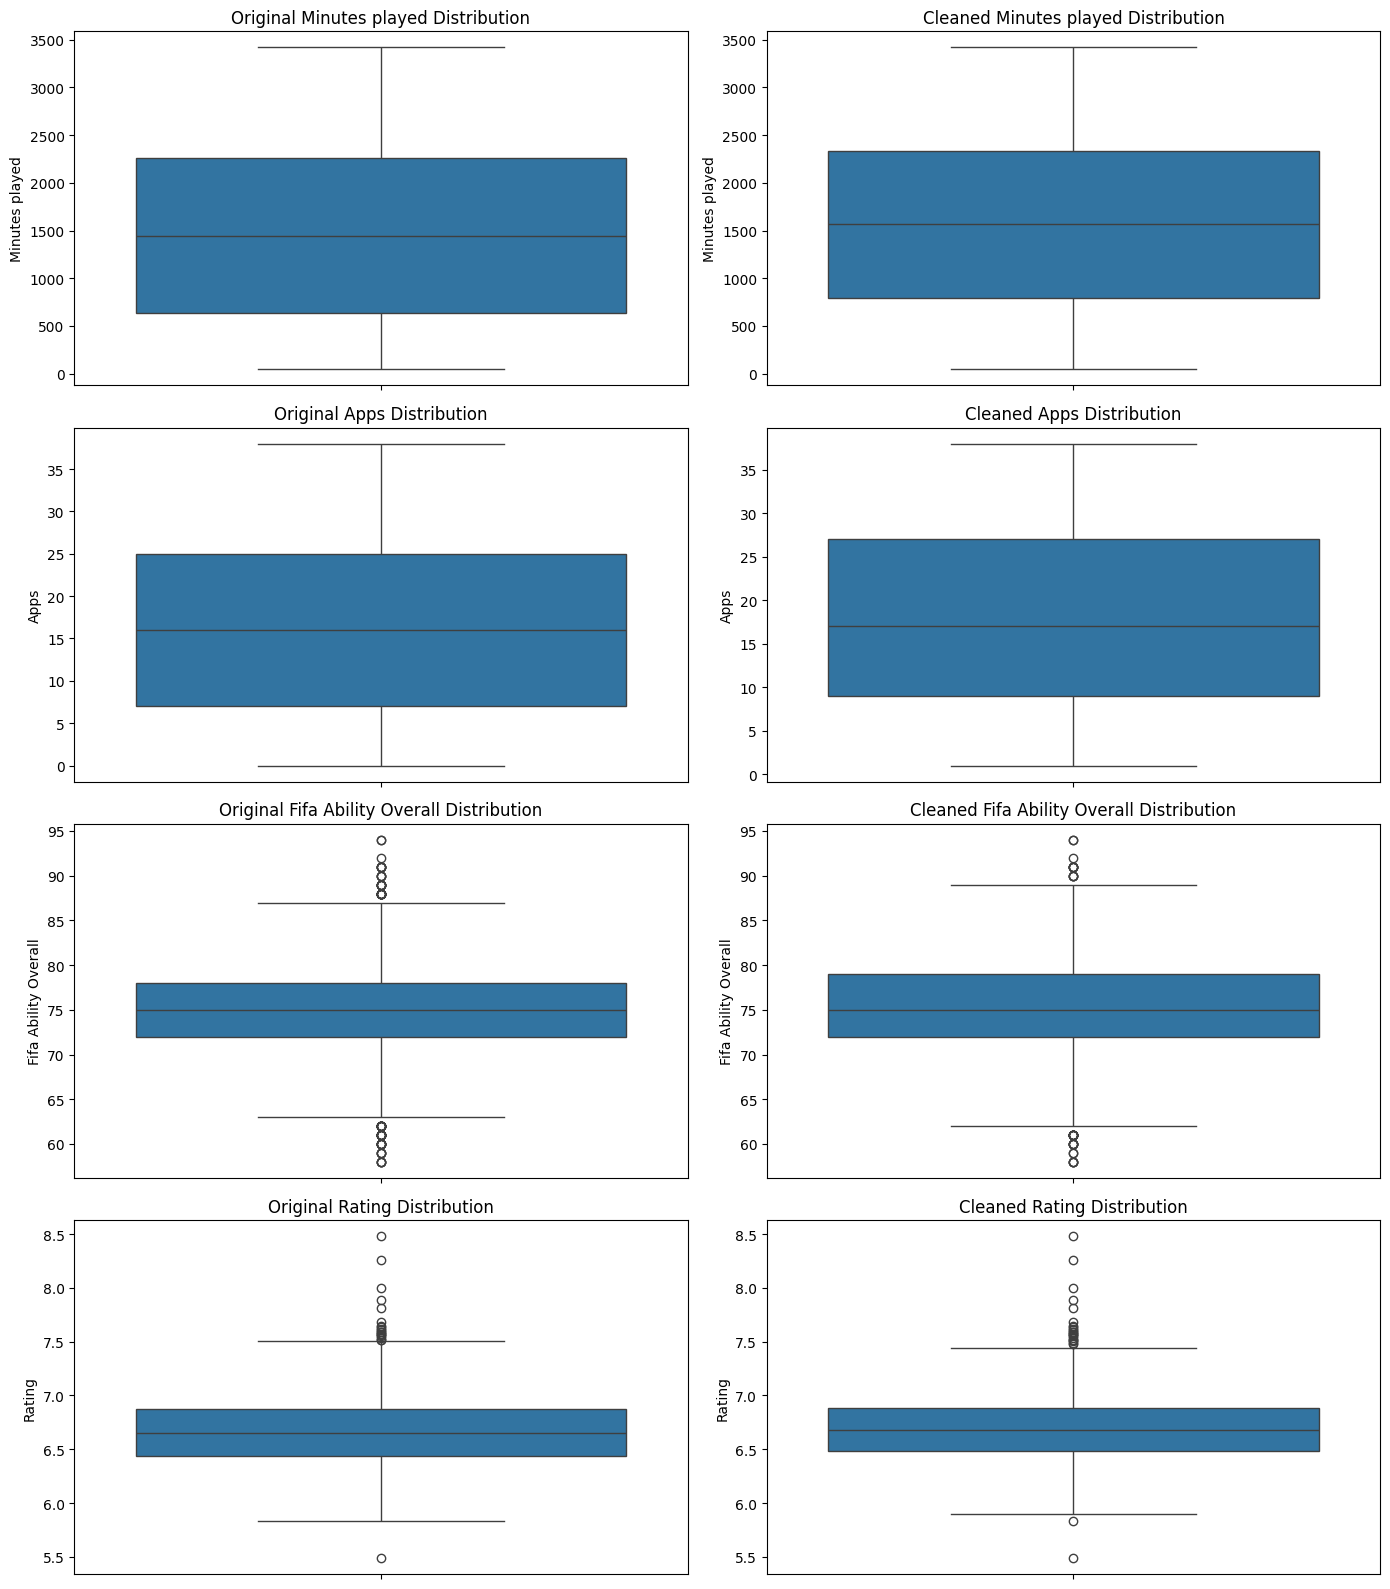

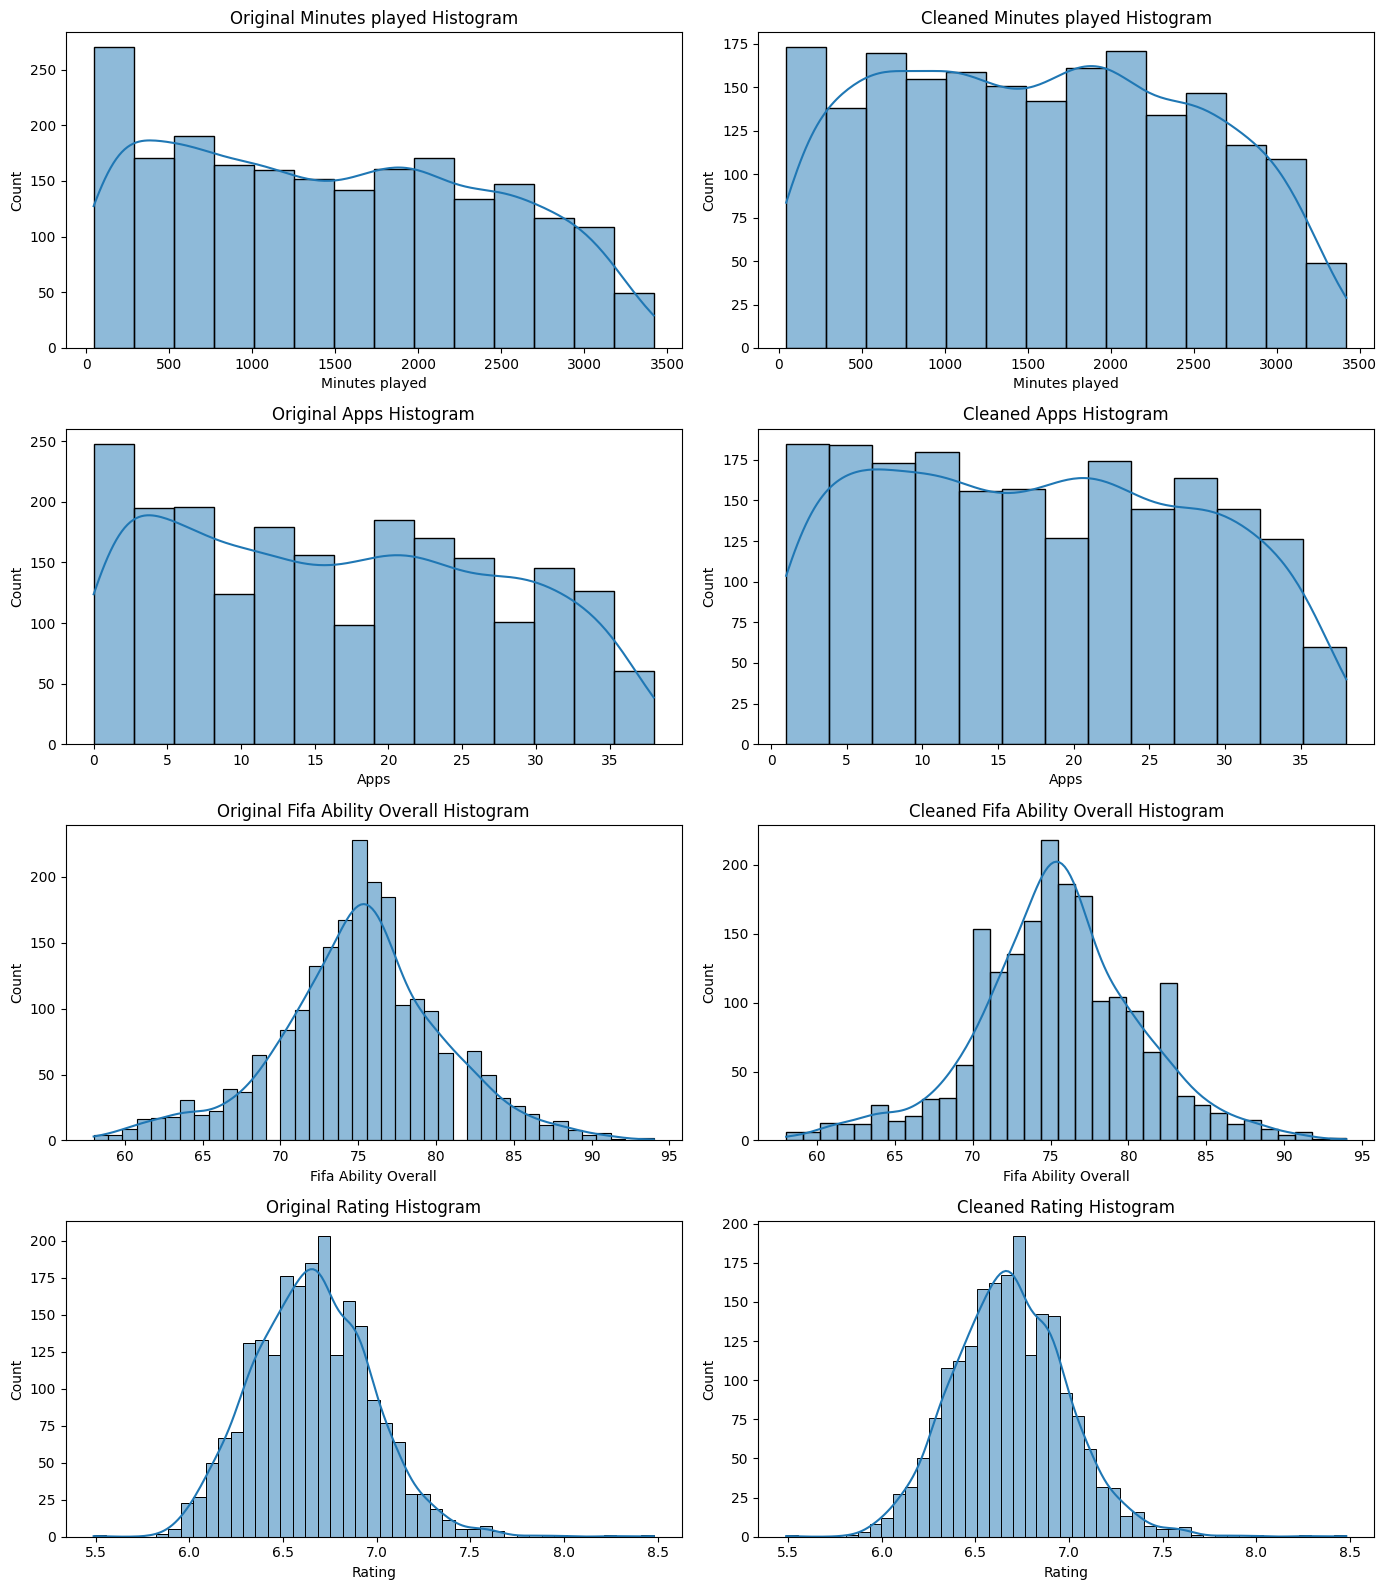

In [52]:
def visualize_cleaning_impact(original_df, cleaned_df, numeric_cols=None):
    """
    Visualize the impact of data cleaning on key numeric variables.
    
    Args:
        original_df (pd.DataFrame): The original dataframe
        cleaned_df (pd.DataFrame): The cleaned dataframe
        numeric_cols (list): List of numeric columns to visualize (if None, selects a few important ones)
    """
    if numeric_cols is None:
        # Select a few important numeric columns if available
        potential_cols = ['Minutes played', 'Apps', 'Fifa Ability Overall', 'Rating']
        numeric_cols = [col for col in potential_cols if col in original_df.columns and col in cleaned_df.columns]
        
        # If none of the suggested columns are available, take the first few numeric columns
        if not numeric_cols:
            numeric_cols = original_df.select_dtypes(include=['int64', 'float64']).columns[:4].tolist()
    
    # Create subplots
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 4*len(numeric_cols)))
    
    # Flatten axes if there's only one row
    if len(numeric_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(numeric_cols):
        # Boxplot
        sns.boxplot(y=original_df[col], ax=axes[i, 0])
        axes[i, 0].set_title(f'Original {col} Distribution')
        
        sns.boxplot(y=cleaned_df[col], ax=axes[i, 1])
        axes[i, 1].set_title(f'Cleaned {col} Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Create before/after histograms
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 4*len(numeric_cols)))
    
    # Flatten axes if there's only one row
    if len(numeric_cols) == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(numeric_cols):
        # Histogram
        sns.histplot(original_df[col], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Original {col} Histogram')
        
        sns.histplot(cleaned_df[col], kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Cleaned {col} Histogram')
    
    plt.tight_layout()
    plt.show()


visualize_cleaning_impact(main_sheet, cleaned_main)


=== Minutes vs Apps Analysis (After Cleaning) ===


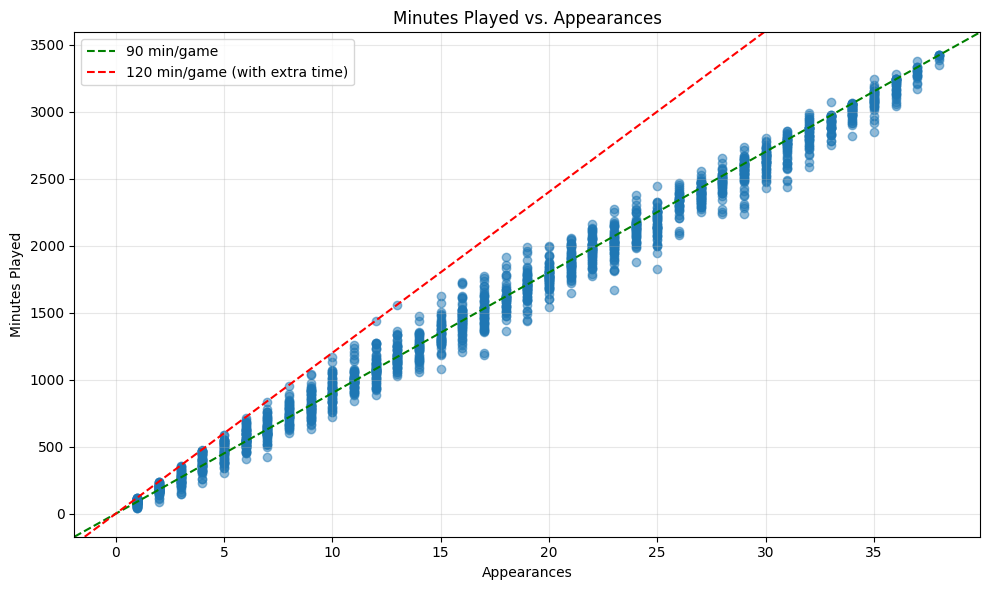

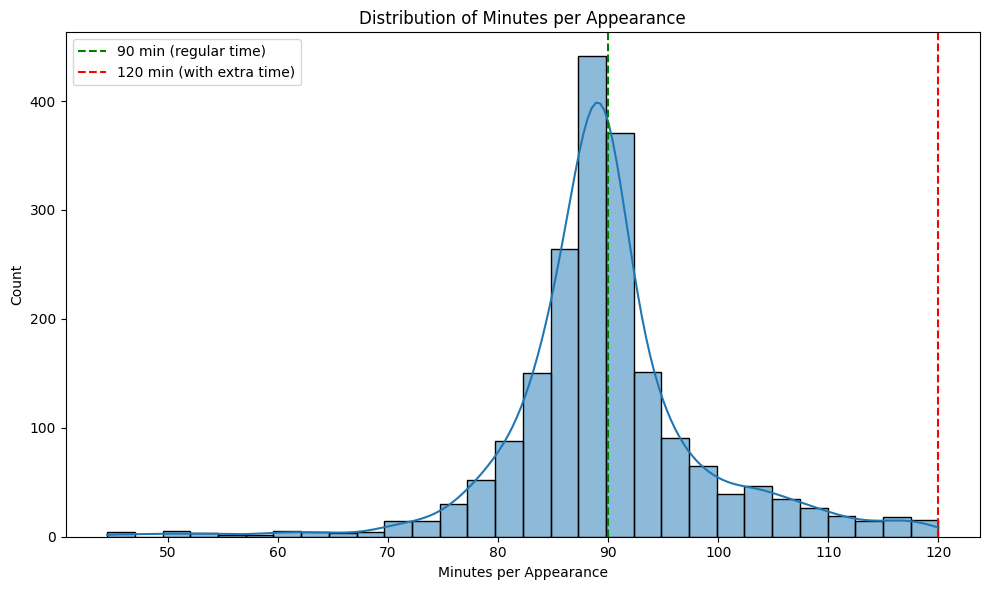


Minutes per Appearance Statistics:
count    1976.000000
mean       89.859739
std         8.953606
min        44.500000
25%        86.000000
50%        89.264706
75%        92.732955
max       120.000000
Name: Minutes_per_App, dtype: float64


In [53]:
   # Analyze minutes vs apps relationship after cleaning
print("\n=== Minutes vs Apps Analysis (After Cleaning) ===")
minutes_vs_apps_analysis(cleaned_main)

In [54]:
def apply_cleaning_to_all_sheets(sheets_data):
    """Apply cleaning to all sheets in the dataset"""
    cleaned_sheets = {}
    
    for sheet_name, df in sheets_data.items():
        print(f"\n=== Cleaning {sheet_name} Sheet ===")
        cleaned_df, results = clean_dataset(df)
        cleaned_sheets[sheet_name] = cleaned_df
        
        print(f"\nCleaning results for {sheet_name}:")
        print(f"- Original rows: {results['original_rows']}")
        print(f"- Rows with missing values removed: {results['missing_values_removed']}")
        print(f"- Outliers removed: {results['outliers_removed']}")
        print(f"- Inconsistent minutes/apps removed: {results['inconsistent_minutes_removed']}")
        print(f"- Final row count: {cleaned_df.shape[0]}")
    
    return cleaned_sheets    

def save_cleaned_data(cleaned_sheets, output_filename='Cleaned_Data.xlsx'):
    """Save all cleaned sheets to a new Excel file"""
    with pd.ExcelWriter(output_filename) as writer:
        for sheet_name, df in cleaned_sheets.items():
            df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f"\nCleaned data saved to {output_filename}")

CHECKPOINT:  save cleaned sheets and we can restart from here, with the cleaned data set. to extract the individual
sheets, call functions from cell 1: read file() and explore_dataframe() 

In [55]:
# Clean all sheets
print("\n=== Cleaning All Sheets ===")
cleaned_sheets = apply_cleaning_to_all_sheets(sheets_data)
 
 # Save the cleaned data
save_cleaned_data(cleaned_sheets)


=== Cleaning All Sheets ===

=== Cleaning Data Sheet ===

--- Cleaning Dataset ---

Missing values before cleaning:
Series([], dtype: int64)

Rows removed due to missing values: 0

Rows removed due to outliers in Minutes played: 0

Rows removed due to duplicates: 0

Rows with zero appearances to be removed (55):
['Denis Suárez', 'Sergio Camello', 'Markel Bergara', 'Roberto Piccoli', 'Paul Baysse', 'Andrea Ranocchia', 'Yoric Ravet', 'Oumar Niasse', 'Marc Stendera', 'Yoann Gourcuff', 'Ramadan Sobhi', 'Harrison Manzala', 'Léo Bonatini', 'Marco Sau', 'Lucas Piazon', 'Pascal Köpke', 'Paulinho', 'Berkay Özcan', 'Álex Alegría', 'Tomas Hubocan', 'Connor Wickham', 'Neeskens Kebano', 'José Arnáiz', 'Arnold Bouka Moutou', 'Alexander Sørloth', 'Marko Pajac', 'Dawid Kownacki', 'Levan Mchedlidze', 'Rajko Brezancic', 'Facundo Píriz', 'Jazz Richards', 'Andrea Favilli', 'Souleymane Camara', 'Javi Sánchez', 'Seung-Ho Paik', 'Gorka Guruzeta', 'Pietro Pellegri', 'Dennis Jastrzembski', 'Cristo González', 